In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from matplotlib.colors import to_rgb
from sklearn import linear_model
import seaborn as sns
from pyprojroot import here

import json
from datetime import datetime
from collections import Counter

# Linking the processed annotation data to survey data and computing synthetic ratings
This notebook uses the self-reported media diet data from the Sparkman et al. (2022) survey to estimate the viewership of each media outlet for each participant, summarizing the results in Figure 2.

## Figure style

In [4]:
colors=['#19bdff','#f2d138'] #majority/minority
greycolor='#626262'
myblack='#222222'
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Load data and format it

In [5]:
##import survey data from Sparkman et al.
df = pd.read_csv(here('data/survey_data/participant_data.csv'))

In [6]:
#create a copy of the dataframe to prevent altering the dataset
dfmedia=df.copy()

In [7]:
medialist=['CNN','NYT','ABC','NPR','FOX','Cons','Lib']

# add a column for each media category based on consuming once a week or more
dfmedia['CNN']=np.where((dfmedia["GRID_GTS3_1_GTS3"]>=3),True,False)
dfmedia['NYT']=np.where((dfmedia["GRID_GTS3_3_GTS3"]>=3),True,False)
dfmedia['ABC']=np.where((dfmedia["GRID_GTS3_4_GTS3"]>=3),True,False)
dfmedia['NPR']=np.where((dfmedia["GRID_GTS3_5_GTS3"]>=3),True,False)
dfmedia['FOX']=np.where((dfmedia["GRID_GTS3_6_GTS3"]>=3),True,False)
dfmedia['Cons']=np.where((dfmedia["GRID_GTS3_7_GTS3"]>=3),True,False)
dfmedia['Lib']=np.where((dfmedia["GRID_GTS3_8_GTS3"]>=3),True,False)




In [8]:
# convert ordinal variables to approximate number of days a month that they consume a given media channel
def weigh_by_freq(response):
    if response==1:
        return 0
    elif response==2:
        return 1 
    elif response==3:
        return 5
    elif response==4:
        return 15
    elif response==5:
        return 30
    else:
        return 0

#copy columns
alteredmedialist=['CNN_ord','','NYT_ord','ABC_ord','NPR_ord','FOX_ord','Cons_ord','Lib_ord'] #to account for skipping 2 in GTS3
for i in range(1,9):
    if i!=2:

        dfmedia[alteredmedialist[i-1]]=dfmedia["GRID_GTS3_"+str(i)+"_GTS3"]


ordinal_medialist=['CNN_ord','NYT_ord','ABC_ord','NPR_ord','FOX_ord','Cons_ord','Lib_ord']


for string in ordinal_medialist:
    dfmedia[string]=dfmedia[string].apply(weigh_by_freq)



In [9]:
#add a column for diversity of media consumption
dfmedia['number_of_outlets']=dfmedia[['CNN', 'NYT','ABC','NPR','FOX','Cons','Lib']].sum(axis=1)


In [10]:


synthetic_ratings = np.zeros(len(ordinal_medialist))
ratings_dict = {}
unweighted_ratings_dict = {}

for i in range(len(ordinal_medialist)):
    column = ordinal_medialist[i]
    unweighted_sum = dfmedia[column].sum()
    weighted_sum = (dfmedia[column] * dfmedia['Weight']).sum() # make sure to use the weights to make a nationally representative sample
    synthetic_ratings[i] = weighted_sum
    unweighted_ratings_dict[medialist[i]] = unweighted_sum
    ratings_dict[medialist[i]] = weighted_sum

print(ordinal_medialist)
print(synthetic_ratings)



['CNN_ord', 'NYT_ord', 'ABC_ord', 'NPR_ord', 'FOX_ord', 'Cons_ord', 'Lib_ord']
[46485.197443 27049.182855 78663.545978 23121.983553 33820.64975
 19804.811476 12795.859375]


In [11]:
print(ratings_dict)
print(unweighted_ratings_dict)

{'CNN': np.float64(46485.197443), 'NYT': np.float64(27049.182855), 'ABC': np.float64(78663.54597800001), 'NPR': np.float64(23121.983553), 'FOX': np.float64(33820.649750000004), 'Cons': np.float64(19804.811476), 'Lib': np.float64(12795.859375)}
{'CNN': np.int64(46837), 'NYT': np.int64(30700), 'ABC': np.int64(80246), 'NPR': np.int64(24326), 'FOX': np.int64(32272), 'Cons': np.int64(18774), 'Lib': np.int64(12095)}


In [12]:
for key in ratings_dict:
    print(key)
    print (ratings_dict[key]-unweighted_ratings_dict[key])
    print('percent difference')
    print ((ratings_dict[key]-unweighted_ratings_dict[key])/ratings_dict[key])

CNN
-351.8025570000027
percent difference
-0.007568055560727302
NYT
-3650.817145000001
percent difference
-0.1349695909325835
ABC
-1582.4540219999908
percent difference
-0.020116738984059513
NPR
-1204.0164470000018
percent difference
-0.05207236845576706
FOX
1548.6497500000041
percent difference
0.04579006498832874
Cons
1030.811475999999
percent difference
0.052048537662131446
Lib
700.859375
percent difference
0.05477235678045266


In [13]:
N=6119

In [14]:

with open(here('00_data_processing/output/Q1_counts.json'), 'r') as json_file:
    Q1_counts = json.load(json_file)

with open(here('00_data_processing/output/Q2_counts.json'), 'r') as json_file:
    Q2_counts = json.load(json_file)

with open(here('00_data_processing/output/Q3_counts.json'), 'r') as json_file:
    Q3_counts = json.load(json_file)


In [15]:
Q1_counts={key: Q1_counts[key] for key in sorted(Q1_counts.keys())}
Q2_counts={key: Q2_counts[key] for key in sorted(Q2_counts.keys())}
Q3_counts={key: Q3_counts[key] for key in sorted(Q3_counts.keys())}

In [17]:
def combine_counts(counts_dict):
    """
    Combine counts from different categories into grouped totals.

    This function aggregates counts from a dictionary of arrays representing 
    different news outlets into broader categories: cable liberal, TV news, and Fox.

    Parameters:
    -----------
    counts_dict : dict
        A dictionary where keys are news outlet names (e.g., 'CNN', 'MSNBC', 'ABC', etc.) 
        and values are arrays representing counts for those outlets.

    Returns:
    --------
    dict
        A new dictionary with the following keys:
        - 'cable_lib': Combined counts for 'CNN' and 'MSNBC'.
        - 'tv_news': Combined counts for 'ABC', 'CBS', and 'NBC'.
        - 'Fox': Counts for 'Fox'.
    """
    # Initialize a new dictionary to store aggregated counts
    new_dict = {}

    # Combine counts for cable liberal news (CNN and MSNBC)
    new_dict['cable_lib'] = np.array(counts_dict['CNN']) + np.array(counts_dict['MSNBC'])

    # Combine counts for traditional TV news (ABC, CBS, NBC)
    new_dict['tv_news'] = (
        np.array(counts_dict['ABC']) + np.array(counts_dict['CBS']) + np.array(counts_dict['NBC'])
    )

    # Include counts for Fox without modification
    new_dict['Fox'] = np.array(counts_dict['Fox'])

    # Return the aggregated dictionary
    return new_dict


In [18]:
def compute_weighted_counts(combined_counts_dict, ratings_dict):
    """
    Compute weighted counts for grouped categories based on ratings.

    This function takes combined counts of categories (e.g., cable liberal, TV news, Fox) 
    and applies a weighting based on predefined ratings for specific news outlets.

    Parameters:
    -----------
    combined_counts_dict : dict
        A dictionary with keys 'cable_lib', 'tv_news', and 'Fox', where each value is 
        a list or array of counts representing the aggregated data for those categories.
    ratings_dict : dict
        A dictionary where keys are news outlet names (e.g., 'CNN', 'ABC', 'FOX'), and 
        values are numeric ratings used as weights for the counts.

    Returns:
    --------
    dict
        A new dictionary with the same keys as `combined_counts_dict`:
        - 'cable_lib': Weighted counts for the cable liberal category.
        - 'tv_news': Weighted counts for the TV news category.
        - 'Fox': Weighted counts for Fox.
    """
    # Initialize a new dictionary to store weighted counts
    new_dict = {}

    # Apply CNN ratings to cable_lib counts
    new_dict['cable_lib'] = [item * ratings_dict['CNN'] for item in combined_counts_dict['cable_lib']]

    # Apply ABC ratings to tv_news counts
    new_dict['tv_news'] = [item * ratings_dict['ABC'] for item in combined_counts_dict['tv_news']]

    # Apply FOX ratings to Fox counts
    new_dict['Fox'] = [item * ratings_dict['FOX'] for item in combined_counts_dict['Fox']]

    # Return the dictionary with weighted counts
    return new_dict


In [19]:
Q1_combined_counts_dict=combine_counts(Q1_counts)
Q1_weighted_counts=compute_weighted_counts(Q1_combined_counts_dict,ratings_dict)

Q2_combined_counts_dict=combine_counts(Q2_counts)
Q2_weighted_counts=compute_weighted_counts(Q2_combined_counts_dict,ratings_dict)

Q3_combined_counts_dict=combine_counts(Q3_counts)
Q3_weighted_counts=compute_weighted_counts(Q3_combined_counts_dict,ratings_dict)

In [20]:

def convert_to_serializable(d):
    return {
        k: float(v) if isinstance(v, (int, float)) else [float(x) for x in v]
        for k, v in d.items()
    }

with open("output/Q1_weighted_counts.json", "w") as f:
    json.dump(convert_to_serializable(Q1_weighted_counts), f, indent=4)

with open("output/Q2_weighted_counts.json", "w") as f:
    json.dump(convert_to_serializable(Q2_weighted_counts), f, indent=4)

with open("output/Q3_weighted_counts.json", "w") as f:
    json.dump(convert_to_serializable(Q3_weighted_counts), f, indent=4)


In [21]:

Q1_choices=["Acknowledges","Neutral","Denies","Debate","Unclear"]
Q2_choices=["Expresses climate concern","Neutral","Expresses opposition to climate concern","Debate","Unclear"]
Q3_choices=["Supports","Neutral","Opposes","Debate","Unclear","No mention"]

short_Q2_choices=['Concern',
 'Neutral',
 'Opposition',
 'Debate',
 'Unclear']


In [22]:
Q3_ratio = {
    key: val[0] / (val[0] + val[2]) if (val[0] + val[2]) != 0 else np.nan
    for key, val in Q3_combined_counts_dict.items()
}



In [23]:
Q3_ratio

{'cable_lib': np.float64(0.9733096085409253),
 'tv_news': np.float64(0.8780487804878049),
 'Fox': np.float64(0.06319702602230483)}

In [24]:
Q3_ratio_include_all = {
    key: val[0] / (val[0] + val[1] + val[2]+ val[3]) if (val[0] + val[1] + val[2]+ val[3]) != 0 else np.nan
    for key, val in Q3_combined_counts_dict.items()
}


## Make histogram

In [25]:
# Select the relevant columns and rename them
df_media_diet= dfmedia[["Respondent_Serial", "CNN_ord", "ABC_ord", "FOX_ord", "Weight"]].copy()
df_media_diet.rename(columns={
    "CNN_ord": "cable_lib",
    "ABC_ord": "tv_news",
    "FOX_ord": "fox_news"
}, inplace=True)

# Add a column for the total
df_media_diet["total"] = df_media_diet[["cable_lib", "tv_news", "fox_news"]].sum(axis=1)


In [26]:
# Step 2: Normalize each row to sum to 1 (i.e., convert to fractions)
fraction_cols = ['cable_lib', 'tv_news', 'fox_news']
df_media_diet[fraction_cols] = df_media_diet[fraction_cols].div(
    df_media_diet[fraction_cols].sum(axis=1), axis=0
)


In [27]:
df_media_diet = df_media_diet.dropna()

In [28]:

# Step 3: Use ratios to compute percent_support column
df_media_diet = df_media_diet.copy()
df_media_diet["fraction_support"] = (
    df_media_diet["cable_lib"] * Q3_ratio["cable_lib"] +
    df_media_diet["tv_news"] * Q3_ratio["tv_news"] +
    df_media_diet["fox_news"] * Q3_ratio["Fox"]
)

df_media_diet["fraction_support_include_all"] = (
    df_media_diet["cable_lib"] * Q3_ratio_include_all["cable_lib"] +
    df_media_diet["tv_news"] * Q3_ratio_include_all["tv_news"] +
    df_media_diet["fox_news"] * Q3_ratio_include_all["Fox"]
)



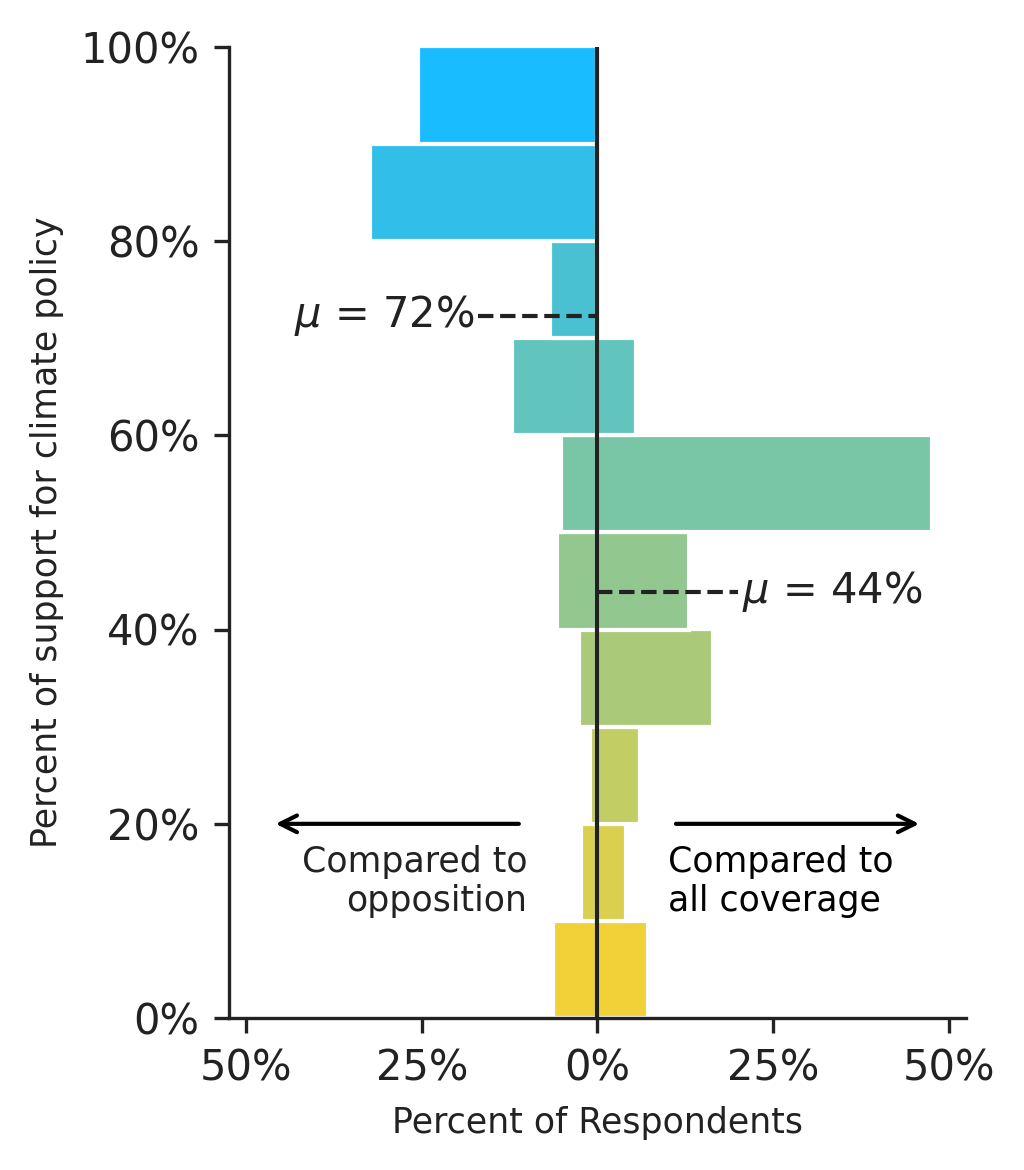

In [ ]:
# Define bin edges and centers
bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

# Histogram for fraction_support (left)
left_counts, _ = np.histogram(df_media_diet["fraction_support"], bins=bins, weights=df_media_diet["Weight"])
left_props = left_counts / left_counts.sum()

# Histogram for fraction_support_include_all (right)
right_counts, _ = np.histogram(df_media_diet["fraction_support_include_all"], bins=bins,weights=df_media_diet["Weight"])
right_props = right_counts / right_counts.sum()

# Gradient color (same across both sides)
start_color = np.array(to_rgb("#f2d138"))  # gold
end_color = np.array(to_rgb("#19bdff"))    # blue
colors = [
    start_color + (end_color - start_color) * i / (len(bin_centers) - 1)
    for i in range(len(bin_centers))
]

# Plot
fig, ax = plt.subplots(figsize=(3.42, 4), dpi=300)

# Left side (fraction_support) — plot as negative bars
for i in range(len(bin_centers)):
    ax.barh(
        bin_centers[i],
        -left_props[i],  # negative for left side
        height=bin_width,
        color=colors[i],
        edgecolor="white"
    )

# Right side (fraction_support_include_all)
for i in range(len(bin_centers)):
    ax.barh(
        bin_centers[i],
        right_props[i],
        height=bin_width,
        color=colors[i],
        edgecolor="white"
    )

# add axis
ax.axvline(0, color=myblack, linewidth=1)

# # Annotate means as horizontal lines
mu_left = np.average(
    df_media_diet["fraction_support"],
    weights=df_media_diet["Weight"]
)

mu_right= np.average(
    df_media_diet["fraction_support_include_all"],
    weights=df_media_diet["Weight"]
)



# Annotate mean lines (only on correct side)
ax.hlines(mu_left, xmin=-max(left_props)*1.05/2, xmax=0, color=myblack, linestyle='--', linewidth=1)
ax.hlines(mu_right, xmin=0, xmax=max(right_props)*1.05/2.5, color=myblack, linestyle='--', linewidth=1)

# Add labels near ends of lines
ax.text(
    -max(left_props)*1.05/2 - 0.005, mu_left,
    f"$\\mu$ = {mu_left*100:.0f}%",
    ha='right',
    va='center',
    color=myblack,
    fontsize=SMALL_SIZE
)

ax.text(
    max(right_props)*1.05/2.5 + 0.005, mu_right,
    f"$\\mu$ = {mu_right*100:.0f}%",
    ha='left',
    va='center',
    color=myblack,
    fontsize=SMALL_SIZE
)


# Add arrows and annotations
ax.annotate("", xy=(-0.1,0.2), xytext=(-0.47,0.2), arrowprops=dict(facecolor=myblack, arrowstyle='<-'))
ax.annotate("Compared to\nopposition", xy=(-0.1, 0.11), size="small", ha="right",color=myblack)

ax.annotate("", xy=(0.1,0.2), xytext=(0.47,0.2), arrowprops=dict(facecolor=myblack, arrowstyle='<-'))
ax.annotate("Compared to\nall coverage", xy=(0.1, 0.11), size="small", ha="left")

# Formatting
ax.set_xlabel("Percent of Respondents", fontsize="small", color=myblack)
ax.set_ylabel("Percent of support for climate policy", fontsize="small", color=myblack)
# ax.set_title("Percent of support for climate policy", fontsize=MEDIUM_SIZE, color=myblack)

# Format x-axis as percent, centered at 0
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{abs(int(round(x * 100)))}%"))
ax.set_xlim(-max(right_props)*1.1, max(right_props)*1.1)

# Format y-axis as percent (media diet support bins)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.tick_params(axis='both', labelsize=SMALL_SIZE, colors=myblack)
ax.set_ylim(0,1)

# Style spines
for spine in ax.spines.values():
    spine.set_color(myblack)

sns.despine()
plt.tight_layout()
plt.savefig(here('99_figures/weighted_by_views_individuals.pdf'))
plt.show()
